In [1]:
import torch
import torch.nn.functional as F
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
import json
from tqdm import tqdm
import gc
import seaborn as sns
import pickle

import numpy as np
import pandas as pd

from imblearn.under_sampling import RandomUnderSampler 
from sklearn.metrics import classification_report

sns.set_context("notebook", font_scale=1.25)

In [2]:
with open('preprocessed.pickle', 'rb') as handle:
    mydict = pickle.load(handle)
    
truth = mydict['truth']
segments = mydict['segments']
m = mydict['m']

In [3]:
mm = m.copy()

### classifier

In [56]:
mm.segment.unique()

array(['preamble', 'instruction', 'input', 'question', 'postilla',
       'generated'], dtype=object)

In [57]:
# minimum number of generated tokens
mm[(mm.segment=='generated')].groupby('pid').tokzero.max().min()

14

In [118]:
# beginning of generation
ds = mm[(mm.segment=='generated') & (mm.tokzero.isin([1,4,8]))][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]

In [120]:
# ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['maxp']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

In [121]:
ds

,run,pid,maxp1,maxp4,maxp8,correct,hallucinated
0,0,9,1.000000,1.0,1.0,False,False
1,0,10,1.000000,1.0,1.0,False,False
2,0,12,1.000000,1.0,1.0,False,False
3,0,14,1.000000,1.0,1.0,False,False
4,0,17,0.899121,1.0,1.0,True,False
...,...,...,...,...,...,...,...
3435,4,1788,1.000000,1.0,1.0,True,False
3436,4,1789,1.000000,1.0,1.0,True,False
3437,4,1790,1.000000,1.0,1.0,False,False
3438,4,1794,1.000000,1.0,1.0,True,False


In [122]:
ds.correct.value_counts()

correct
True     2374
False    1066
Name: count, dtype: int64

In [123]:
y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

In [124]:
X.loc[:,X.nunique()!=1].shape

(3440, 3)

In [125]:
X.isnull().sum().sum() == 0

True

In [126]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [127]:
X_res.columns = ['generated_'+col for col in X.columns]

In [128]:
X_res.isnull().sum().sum() == 0

True

In [129]:
X_res

,generated_maxp1,generated_maxp4,generated_maxp8
0,1.00000,1.0,1.0
1,1.00000,1.0,1.0
2,1.00000,1.0,1.0
3,1.00000,1.0,1.0
7,1.00000,1.0,1.0
...,...,...,...
3217,1.00000,1.0,1.0
1893,1.00000,1.0,1.0
214,1.00000,1.0,1.0
2203,0.73412,1.0,1.0


### beginning of generation

In [130]:
%%time

from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict

from xgboost import XGBRFRegressor, XGBRFClassifier
import xgboost

#partition cv by prompt
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)

# pred = cross_val_predict(xgb_model, X, y, cv=GroupKFold(n_splits=10), groups=pids)
# pred_proba = cross_val_predict(xgb_model, X, y, cv=LeaveOneGroupOut(), groups=pids, method='predict_proba')
pred_proba = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 1.57 s, sys: 831 ms, total: 2.4 s
Wall time: 337 ms


In [131]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.70      0.38      0.49      1066
        True       0.57      0.84      0.68      1066

    accuracy                           0.61      2132
   macro avg       0.64      0.61      0.59      2132
weighted avg       0.64      0.61      0.59      2132



In [110]:
pred = pred_proba.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.72      0.52      0.60      1066
        True       0.62      0.80      0.70      1066

    accuracy                           0.66      2132
   macro avg       0.67      0.66      0.65      2132
weighted avg       0.67      0.66      0.65      2132



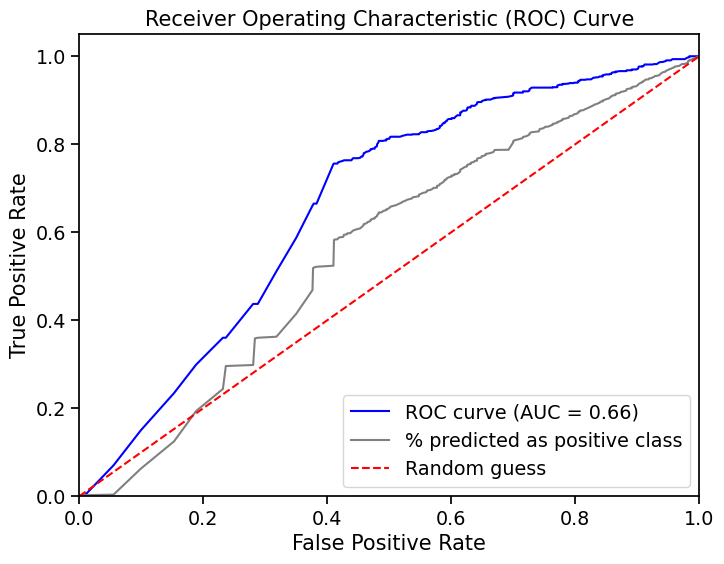

In [111]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / len(y_res.values) for thr in thresholds]

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot(fpr, true_counts_rel, color='grey', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [112]:
import xgboost
import shap

model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

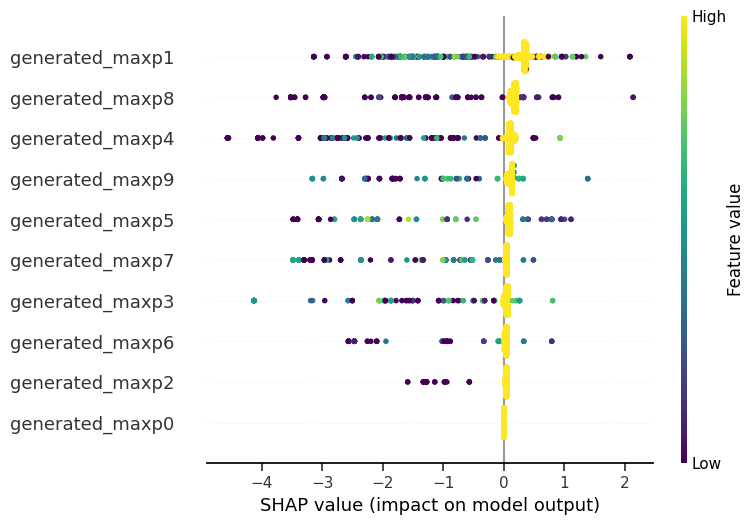

In [113]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

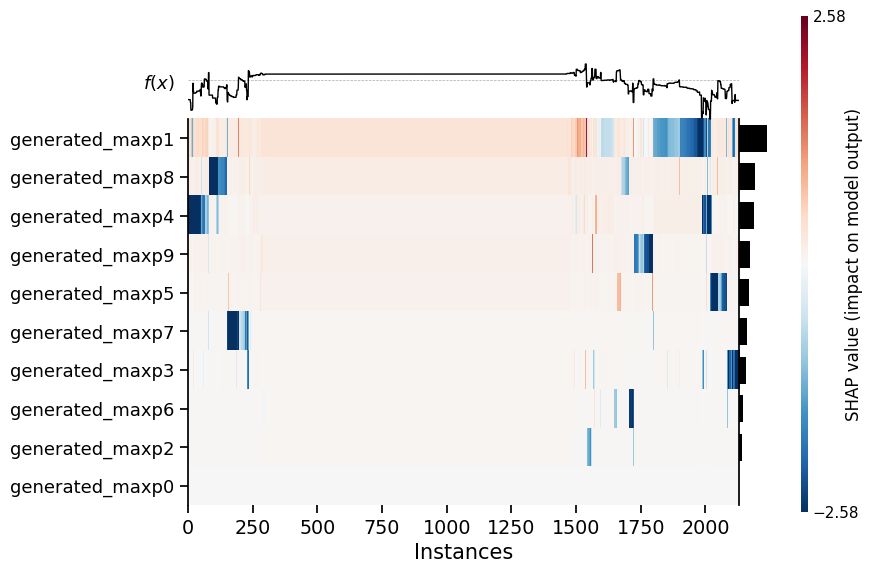

In [114]:
shap.plots.heatmap(shap_values, cmap="RdBu_r")

In [22]:
#clustering = shap.utils.hclust(X_res, y_res)
#shap.plots.bar(shap_values, clustering=clustering, max_display=20, clustering_cutoff=1)

In [23]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [24]:
vals.groupby('grp').value.sum()

grp
generated_maxp    1.0
Name: value, dtype: float64

In [25]:
K = 5
top_feat_generated_begin = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

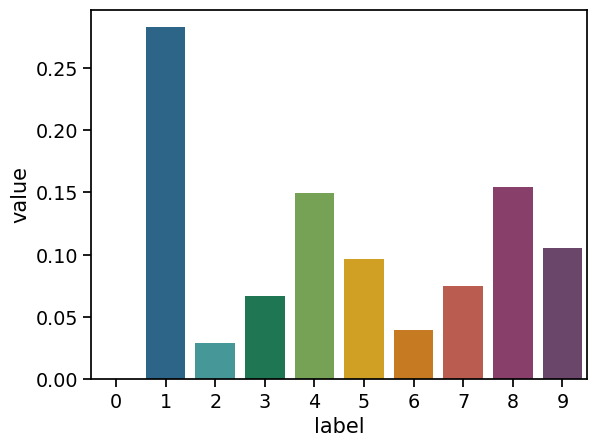

In [26]:
from palettable.cartocolors.qualitative import Prism_10, Bold_10
palette = Prism_10.mpl_colors 

index_importances = vals.sort_index().groupby('label').value.sum()

sns.barplot(index_importances, palette=palette)

### end of postilla

In [27]:
mm[(mm.segment=='postilla')].tokzero.max()

64

In [28]:
# end of ...
# ds = mm[(mm.segment=='postilla') & (mm.tokzero_end>=-10)][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds = ds.merge(truth, on=['run', 'pid'])

y = ds.correct
pids = ds.pid
X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

X_res.columns = ['postilla_'+col for col in X.columns]

In [29]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
# pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=LeaveOneGroupOut(), groups=pids_res, method='predict_proba')
pred_proba_instr = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 26.6 s, sys: 3.8 s, total: 30.4 s
Wall time: 4.72 s


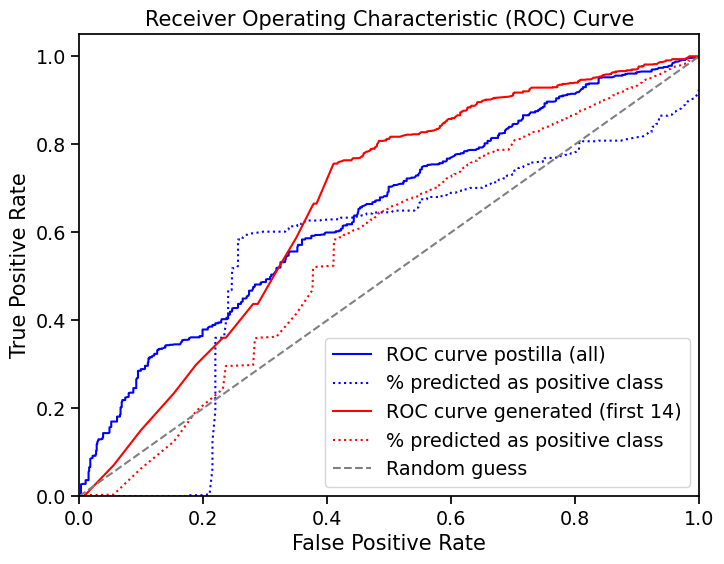

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [31]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

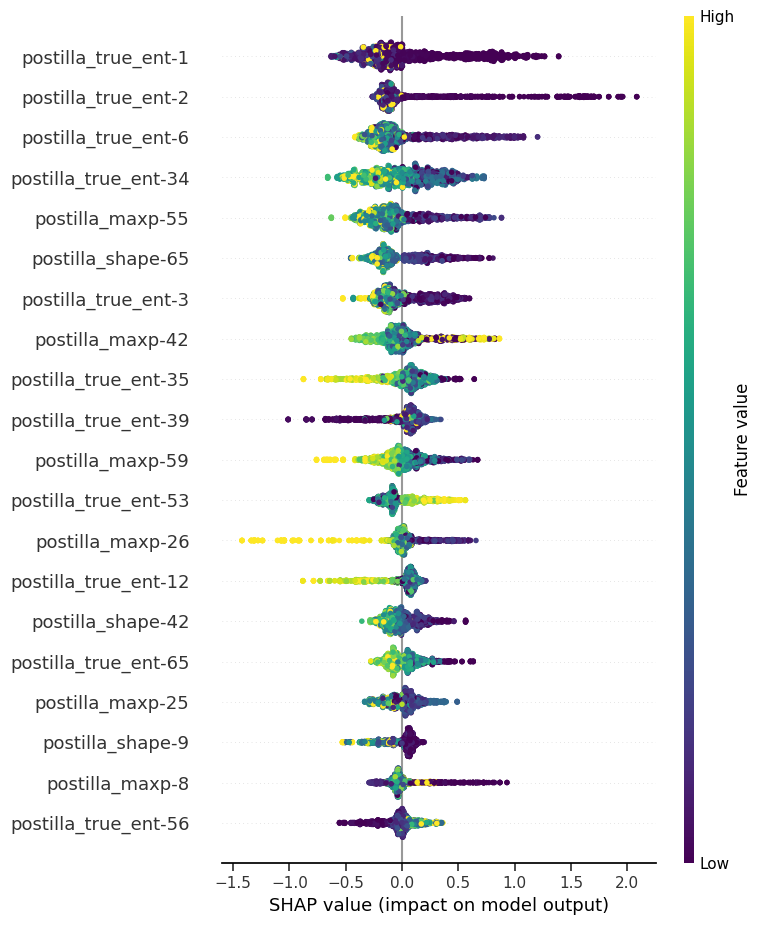

In [32]:
shap.summary_plot(shap_values, X_res, cmap="viridis")

In [33]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if i.isdigit()))
vals['label'] = vals['label'].astype(int)

In [34]:
K = 5
top_feat_postilla_all = vals.sort_values('value', ascending=False)[:K].label_orig.tolist()

In [35]:
vals.groupby('grp').value.sum()

grp
postilla_maxp-        0.375561
postilla_shape-       0.137523
postilla_true_ent-    0.486916
Name: value, dtype: float64



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



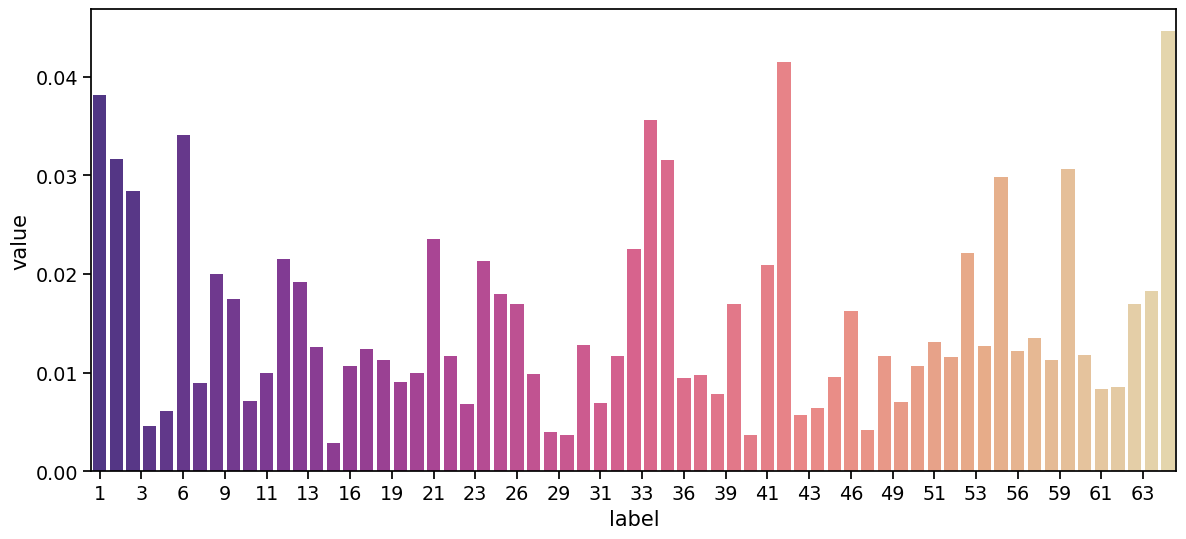

In [36]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

ax.xaxis.set_major_locator(MaxNLocator(nbins=32))

### combo

In [37]:
mm

,run,pid,tok,area,shape,true_ent,maxp,start,end,segment,seq,length,tok_rel_segm,tok_rel_segm_abs,tokzero,tokzero_end
0,0,9,0,prompt,19127,9.342692,0.011505,0,40,preamble,0,40,0.000000,0.000000,0,-41
6,0,9,1,prompt,4954,6.863560,0.110962,0,40,preamble,0,40,0.025000,0.025000,1,-40
12,0,9,2,prompt,9,1.748911,0.684082,0,40,preamble,0,40,0.050000,0.050000,2,-39
18,0,9,3,prompt,178,4.617726,0.093811,0,40,preamble,0,40,0.075000,0.075000,3,-38
24,0,9,4,prompt,5,1.100033,0.811523,0,40,preamble,0,40,0.100000,0.100000,4,-37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68765189,4,1797,5483,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999271,5.826087,19,-5
68765195,4,1797,5484,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999453,5.869565,20,-4
68765201,4,1797,5485,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999636,5.913043,21,-3
68765207,4,1797,5486,generated,1,0.000000,1.000000,5464,5487,generated,5,23,0.999818,5.956522,22,-2


In [38]:
# COMBO
# beginning of generate + postilla

ds = mm[(mm.segment=='generated') & (mm.tokzero<=10)][['run', 'pid', 'tokzero', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds1 = ds.merge(truth, on=['run', 'pid'])
ds1.columns = ['generated_' + col if col[-1].isdigit() else col for col in ds1.columns]

# all postilla
ds = mm[(mm.segment=='postilla')][['run', 'pid', 'tokzero_end', 'shape', 'true_ent', 'maxp']]
ds = ds.pivot(index=['run', 'pid'], columns='tokzero_end', values=['shape', 'maxp', 'true_ent']).reset_index()
ds.columns = [''.join([str(c) for c in col]).strip() for col in ds.columns.values]
ds2 = ds.merge(truth, on=['run', 'pid'])
ds2.columns = ['postilla_' + col if col[-1].isdigit() else col for col in ds2.columns]

In [39]:
ds = ds1.merge(ds2, on = ['run', 'pid', 'correct', 'hallucinated'])

In [40]:
ds.shape, ds1.shape, ds2.shape

((3440, 232), (3440, 37), (3440, 199))

In [41]:
y = ds.correct
pids = ds.pid

X = ds.drop(columns=['run', 'pid', 'correct', 'hallucinated'])

# SELETC TOP FEATURES ONLY
X = X[top_feat_postilla_all + top_feat_generated_begin]

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
pids_res = pids[y_res.index]

In [42]:
%%time
xgb_model = XGBRFClassifier(n_estimators=100, n_jobs=6)
pred_proba_combo = cross_val_predict(xgb_model, X_res, y_res, cv=GroupKFold(n_splits=10), groups=pids_res, method='predict_proba')

CPU times: user 3.06 s, sys: 1.87 s, total: 4.93 s
Wall time: 632 ms


In [43]:
pred = pred_proba_combo.argmax(axis=1).astype(bool)
print(classification_report(y_res.values, pred))

              precision    recall  f1-score   support

       False       0.63      0.63      0.63      1066
        True       0.63      0.63      0.63      1066

    accuracy                           0.63      2132
   macro avg       0.63      0.63      0.63      2132
weighted avg       0.63      0.63      0.63      2132



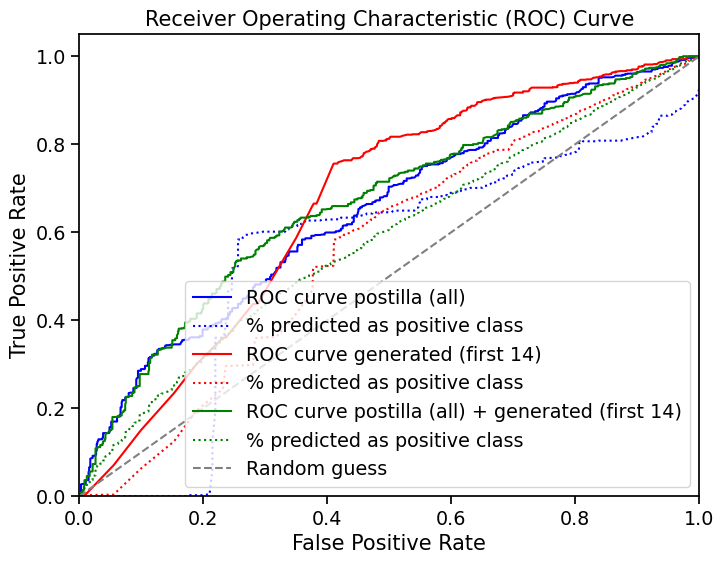

In [44]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_instr[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba_instr.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='blue', label=f'ROC curve postilla (all)')
plt.plot(fpr, true_counts_rel, color='blue', linestyle=':', label=f'% predicted as positive class')


fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba[:, 1])
true_counts_rel = [(pred_proba[:, 1] > thr).sum() / pred_proba.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='red', label=f'ROC curve generated (first 14)')
plt.plot(fpr, true_counts_rel, color='red', linestyle=':', label=f'% predicted as positive class')

fpr, tpr, thresholds = roc_curve(y_res.values, pred_proba_combo[:, 1])
true_counts_rel = [(pred_proba_combo[:, 1] > thr).sum() / pred_proba_combo.shape[0] for thr in thresholds]
plt.plot(fpr, tpr, color='green', label=f'ROC curve postilla (all) + generated (first 14)')
plt.plot(fpr, true_counts_rel, color='green', linestyle=':', label=f'% predicted as positive class')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
model = xgboost.XGBClassifier(n_estimators=100).fit(X_res, y_res)
explainer = shap.Explainer(model, X_res)
shap_values = explainer(X_res)

In [46]:
# https://github.com/shap/shap/blob/master/shap/plots/_bar.py
c = shap_values.abs.mean(0)
features = c.display_data if c.display_data is not None else c.data
feature_names = c.feature_names
op_history = c.op_history
values = np.array([c.values])
vals = pd.DataFrame({'label':shap_values.feature_names, 'value':values[0]}).sort_values('value', ascending=False)
vals.value = vals.value / vals.value.sum()
vals['label_orig'] = vals['label']
vals['grp'] = vals['label'].apply(lambda x : ''.join(i for i in x if not i.isdigit()))
vals['label'] = vals['label'].apply(lambda x : ''.join(i for i in x if (i.isdigit() or i =='-')))
vals['label'] = vals['label'].astype(int)

In [47]:
vals.groupby('grp').value.sum()

grp
generated_maxp        0.358070
postilla_maxp-        0.161379
postilla_true_ent-    0.480551
Name: value, dtype: float64

In [48]:
vals

,label,value,label_orig,grp
4,-55,0.161379,postilla_maxp-55,postilla_maxp-
2,-6,0.159129,postilla_true_ent-6,postilla_true_ent-
3,-34,0.119022,postilla_true_ent-34,postilla_true_ent-
5,1,0.113972,generated_maxp1,generated_maxp
1,-2,0.109087,postilla_true_ent-2,postilla_true_ent-
0,-1,0.093314,postilla_true_ent-1,postilla_true_ent-
6,8,0.080668,generated_maxp8,generated_maxp
7,4,0.076761,generated_maxp4,generated_maxp
8,9,0.049802,generated_maxp9,generated_maxp
9,5,0.036867,generated_maxp5,generated_maxp




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='label', ylabel='value'>

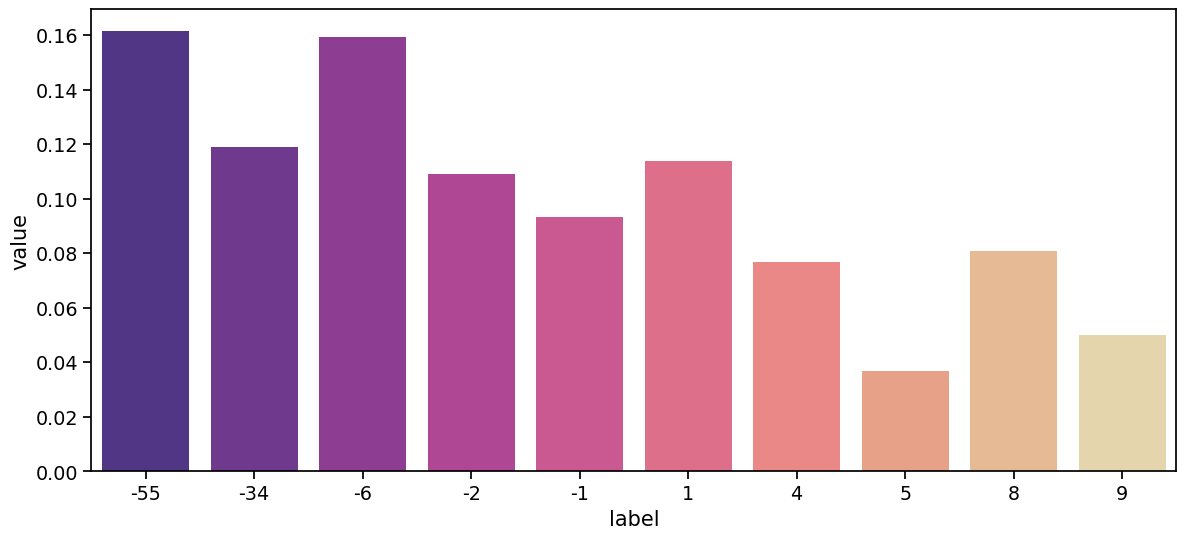

In [54]:
from matplotlib.ticker import MaxNLocator
from palettable.cartocolors.qualitative import Prism_10, Bold_10
from palettable.cartocolors.sequential import agSunset_7
from matplotlib.colors import LinearSegmentedColormap, Normalize


plt.figure(figsize=(14, 6))
ax = plt.gca()

index_importances = vals.sort_index().groupby('label').value.sum().to_frame().reset_index()

# palette = sns.color_palette(agSunset_7, )

norm = Normalize(vmin=0, vmax=index_importances.shape[0] - 1)
color_mapping = {str(label): agSunset_7.mpl_colormap(norm(i)) for i, label in enumerate(index_importances.label)}


sns.barplot(index_importances, x='label', y='value', palette=color_mapping, ax = ax)

# ax.xaxis.set_major_locator(MaxNLocator(nbins=32))